In [1]:
!pip install -q fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os, time, random, re, math, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

from fvcore.nn import FlopCountAnalysis, parameter_count_table

import torch
import torchinfo
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
from torchinfo import summary
from torch.profiler import profile, record_function, ProfilerActivity
# Reproducible seed
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ.get('PYTHONHASHSEED') == str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 


device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device('cpu')
print(f"Used device: {device}\nNumber of devices: {torch.accelerator.device_count()}")

Used device: cuda
Number of devices: 2


In [3]:
df = pd.read_csv('/kaggle/input/emotweetid-human-labeled-dataset/EmoTweetID-Human.csv')
df.drop(columns='Unnamed: 0',inplace=True)
df.head()

,tweet,label
0,wah belom liat muka gue lagi murka hahahaha,joy
1,Mungkin kurang piknik adrenalin. Mereka yg ske...,anger
2,"maaf kalo tersinggung ""orang kurus cepet mati""...",anger
3,berserah pada maha esa paling tabah dan sabar ...,joy
4,Ehekk malu la hahahahahahaha,sadness


## Data Preparation

#### Text cleaning

In [4]:
def clean_text(text):
    if isinstance(text, float):
        return ""
    text = str(text)
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')
    return text.strip()

df['cleaned_text'] = df['tweet'].apply(clean_text)
df.head()

,tweet,label,cleaned_text
0,wah belom liat muka gue lagi murka hahahaha,joy,wah belom liat muka gue lagi murka hahahaha
1,Mungkin kurang piknik adrenalin. Mereka yg ske...,anger,mungkin kurang piknik adrenalin mereka yg skep...
2,"maaf kalo tersinggung ""orang kurus cepet mati""...",anger,maaf kalo tersinggung orang kurus cepet mati w...
3,berserah pada maha esa paling tabah dan sabar ...,joy,berserah pada maha esa paling tabah dan sabar ...
4,Ehekk malu la hahahahahahaha,sadness,ehekk malu la hahahahahahaha


#### build vocabulary

In [5]:
class Vocabulary:
    def __init__(self, min_freq=1):
        self.min_freq = min_freq
        self.special_tokens = ['<pad>', '<unk>', '<cls>', '<sep>']
        self.token2idx = {}
        self.idx2token = {}
        self.frequencies = Counter()

    def build_vocab(self, texts):
        for text in texts:
            tokens = text.split()
            self.frequencies.update(tokens)

        for i, token in enumerate(self.special_tokens):
            self.token2idx[token] = i
            self.idx2token[i] = token

        idx = len(self.special_tokens)
        for token, freq in self.frequencies.items():
            if freq >= self.min_freq and token not in self.token2idx:
                self.token2idx[token] = idx
                self.idx2token[idx] = token
                idx += 1

    def __len__(self):
        return len(self.token2idx)

    def __getitem__(self, token):
        return self.token2idx.get(token, self.token2idx['<unk>'])

    def tokens_to_indices(self, tokens):
        return [self[token] for token in tokens]

    def indices_to_tokens(self, indices):
        return [self.idx2token[idx] for idx in indices]

vocab = Vocabulary(min_freq=2)
vocab.build_vocab(df['cleaned_text'])
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"Most common tokens: {vocab.frequencies.most_common(10)}")

Vocabulary size: 3294
Most common tokens: [('aku', 708), ('yg', 506), ('yang', 363), ('dan', 360), ('di', 331), ('ada', 289), ('sama', 282), ('aja', 274), ('dia', 272), ('ya', 272)]


#### create dataset

In [6]:
class EmotDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

        self.label_encoder = LabelEncoder()
        self.encoded_label = self.label_encoder.fit_transform(labels)
        self.num_classes = len(self.label_encoder.classes_)

    def __len__(self):
        return len(self.texts)

    def text_to_tensor(self, text):
        """Convert text to tensor with padding"""
        tokens = text.split()[:self.max_length]
        token_ids = self.vocab.tokens_to_indices(tokens)

        # pad sequence
        if len(token_ids) < self.max_length:
            padding = [self.vocab['<pad>']] * (self.max_length - len(token_ids))
            token_ids = token_ids + padding

        else:
            token_ids = token_ids[:self.max_length]

        attention_mask = [1] * len(tokens) + [0] * (self.max_length - len(tokens))

        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(attention_mask, dtype=torch.long)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.encoded_label[idx]

        input_ids, attention_mask = self.text_to_tensor(text)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

lengths = df['cleaned_text'].apply(lambda x: len(x.split()))
max_length = min(int(lengths.quantile(0.95)), 512)  # Cap at 512
print(f"Max sequence length: {max_length}")

Max sequence length: 44


#### Data splitting & loaders

In [7]:
set_seed()
# --- First split: Train (70%) + Temp (30%) ---
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_text'], df['label'],
    test_size=0.3,
    random_state=123,
    stratify=df['label']
)

# --- Second split: Validation (15%) + Test (15%) ---
# Since temp is 30% of original, splitting it 0.5/0.5 gives 15% each
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5,
    random_state=123,
    stratify=temp_labels
)

train_dataset = EmotDataset(train_texts, train_labels, vocab, max_length)
val_dataset = EmotDataset(val_texts, val_labels, vocab, max_length)
test_dataset = EmotDataset(test_texts, test_labels, vocab, max_length)

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)


num_classes = train_dataset.num_classes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_dataset.label_encoder.classes_}")

Training samples: 1570
Validation samples: 336
Testing samples: 337
Number of classes: 6
Classes: ['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


In [8]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Number of train batches: {len(train_loader)}")
print(f"Val dataset size: {len(val_loader.dataset)}")
print(f"Number of val batches: {len(val_loader)}")

Train dataset size: 1570
Number of train batches: 50
Val dataset size: 336
Number of val batches: 11


In [9]:
# Test one batch
batch = next(iter(train_loader))
print(f"Batch input_ids shape: {batch['input_ids'].shape}")  # [batch_size, max_length]
print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
print(f"Batch labels shape: {batch['labels'].shape}")

# Show sample data
print(f"\nSample input_ids: {batch['input_ids'][0][:10]}...")  # First 10 tokens
print(f"Sample attention_mask: {batch['attention_mask'][0][:10]}...")
print(f"Sample label: {batch['labels'][0]}")

# Verify padding works
print(f"\nPadding token ID: {vocab['<pad>']}")
print(f"Unknown token ID: {vocab['<unk>']}")

Batch input_ids shape: torch.Size([32, 44])
Batch attention_mask shape: torch.Size([32, 44])
Batch labels shape: torch.Size([32])

Sample input_ids: tensor([   1,    1,  303,  302,    1, 1889, 1728,    1, 1197,  640])...
Sample attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])...
Sample label: 4

Padding token ID: 0
Unknown token ID: 1


## Multihead Attention

In [10]:
class MultiHeadAttention(nn.Module):
    """
    It computes the attention between each pair of positions in a sequence, consisting multiple 'attention heads' to capture different 'important aspects' of the input.

    Arguments:
        d_model = Dimensionality of the input
        num_heads = The number of attention heas to split the input info.
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "model dimension (d_model) must be divisible by num_heads"

        self.d_model = d_model # model's dimension
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        [1] Calculate attention scores by taking the dot product of queries (Q) and keys (K), and then scaling by the square root of the key dimension (d_k).
        [2] Apply the attention scores to mask out specific values, if a mask is provided.
        [3] Convert the attention score into probabilities that sum to 1 by passing it through a softmax function
        [4] Multiply the attention weights (probs) by the values (V)
        """
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        """
        [1] Reshape the input x into the shape (batch_size, num_heads, seq_length, d_k), enabling the model to process multiple attention heads concurrently alowing for parallel computation.
        """
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1,2)

    def combine_heads(self, x):
        """
        [1] Combine the results of applying attention to each head separately back into a single tensor of shape (batch_size, seq_length, d_model)
        """
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1,2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        """
        [1] Apply linear transformation to the queries (Q), keys (K), and values (V) using the weights defined in the initialization.
        [2] The transformed Q, K, V are split into multiple heads using the split_heads method
        [3] Combine the results from each head back into a single tensor.
        [4] Apply output transformation to the combined tensor using a linear transformation
        """
        # linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

## Position-wise feed-forward networks

In [11]:
class PositionWiseFeedForward(nn.Module):
    """
    Define a position-wise feed-forward neural network that consists of two linear layers with a ReLU activation function in between. 
    In the transformer model, this feed-forward network is applied to each position separately and identically.
    Args:
        d_model: Dimensionality of model's input and output
        d_ff: Dimensionality of the inner layer in the feed-forward network
    """
    def __init__(self, d_model, d_ff):
        """
        Two fully connected (linear) layers with input and output dimensions as defined by d_model and d_ff
        """
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

## Positional Encoding

In [12]:
class PositionalEncoding(nn.Module):
    """
    Injects the the position information of each token in the input sequence, using sine and cosine functions of different frequencies to generate the positional encoding
    Args:
        d_model: the dimension of the model's input
        max_seq_length: the maximum length of the sequence of which position encoding are pre-computed
        pe: a tensor filled with zeros, which will be populated with positional encodings
        position: a tensor containing the positio indices for each position in the sequence
        div_term: a term used to scale the position indices in a specific wa

    Extra:
        the sine function is applied to the even indices and the cosine function to the odd indices of pe
        then pe is registered as a buffer, which means it will be part of the modules' state but will not be considered a trainable parameter.
    """
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                             -(math.log(10000.0)/d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

## Encoder Blocks

In [13]:
class EncoderLayer(nn.Module):
    """
    Args:
        d_model: the dimensionality of the input
        num_heads: the number of attention heads in the multi-head attention
        d_ff: the dimensionality of the inner layer in the position-wise feed-forward network
        dropout: the dropout rate used for regularization
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

## Neural Network

In [14]:
class EmotNet(nn.Module):
    """
    Transformer-based classifier network.

    Uses:
      - Token + Positional embeddings
      - CLS token for classification
      - Stacked EncoderLayers (each with multi-head attention + FFN)
      - Final MLP classifier on CLS representation
    """
    def __init__(self, vocab_size, d_model=64, nhead=4,
                 num_layers=2, num_classes=6, max_seq_length=128, dropout=0.1):
        super(EmotNet, self).__init__()

        # === Embedding layers ===
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length + 1)
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        # === Transformer encoder stack ===
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, nhead, d_model * 4, dropout)
            for _ in range(num_layers)
        ])

        # === Classification head ===
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        # [CLS] token (learnable parameter)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

    def forward(self, x, attention_mask=None):
        """
        Args:
            x: (batch_size, seq_len)
            attention_mask: (batch_size, seq_len), with 1 for valid tokens and 0 for padding
        Returns:
            output: (batch_size, num_classes)
        """
        batch_size, seq_len = x.shape

        # === 1. Token + CLS embeddings ===
        token_embeddings = self.token_embedding(x) * math.sqrt(self.d_model)  # (B, L, D)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)                # (B, 1, D)
        embeddings = torch.cat([cls_tokens, token_embeddings], dim=1)         # (B, L+1, D)

        # === 2. Add positional encoding ===
        embeddings = self.pos_encoding(embeddings)
        embeddings = self.dropout(embeddings)

        # === 3. Prepare attention mask ===
        if attention_mask is not None:
            cls_mask = torch.ones(batch_size, 1, device=attention_mask.device)
            extended_mask = torch.cat([cls_mask, attention_mask], dim=1)  # (B, L+1)
            # transform mask to shape (B, 1, 1, L+1)
            mask = extended_mask.unsqueeze(1).unsqueeze(2)
        else:
            mask = None

        # === 4. Pass through encoder layers ===
        x = embeddings
        for layer in self.encoder_layers:
            x = layer(x, mask) 

        # === 5. Take CLS token representation ===
        cls_output = x[:, 0, :]  # (B, D)

        # === 6. Classification ===
        output = self.classifier(cls_output)  # (B, num_classes)
        return output

## Traning with early stopping function

In [15]:
def training_with_early_stopping(
    model, train_loader, val_loader, loss_fn, optimizer, epochs, device, es_flag=False,
    patience=3, profile_run=False, profile_dir="profiling",
):
    os.makedirs(profile_dir, exist_ok=True)

    history = {
    'train_loss': [], 'train_acc': [], 
    'val_loss': [], 'val_acc': [],
    'train_time_s': [], 'val_time_s': [], 'epoch_time_s': [] 
    }
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None


    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()

        train_start = time.time()
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0
        start = time.time()
        if profile_run and epoch == 0:
            print("[Profiler] Profiling one epoch...")
            with profile(
                activities=[ProfilerActivity.CPU],
                record_shapes=True,
                profile_memory=True,
                with_stack=True,
                on_trace_ready=torch.profiler.tensorboard_trace_handler(profile_dir)
            ) as prof:
                for i, batch in enumerate(train_loader):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask) 
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    prof.step()

                    # Accumulate metrics
                    train_loss += loss.item() * input_ids.size(0)
                    train_correct += (outputs.argmax(1) == labels).sum().item()
                    total_train += input_ids.size(0)
                    if i == 0:
                        break                    
        else:
            for batch in train_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * input_ids.size(0)
                train_correct += (outputs.argmax(1) == labels).sum().item()
                total_train += input_ids.size(0)
        train_time = time.time() - train_start
        
        # Validation
        val_start = time.time()
        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0
        with torch.inference_mode():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)  # FIX: Pass both inputs
                val_loss += loss_fn(outputs, labels).item() * input_ids.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                total_val += input_ids.size(0)

        val_time = time.time() - val_start

        epoch_time = time.time() - epoch_start
        
        train_loss /= total_train
        val_loss /= total_val
        train_acc = train_correct / total_train
        val_acc = val_correct / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['train_time_s'].append(train_time)
        history['val_time_s'].append(val_time)
        history['epoch_time_s'].append(epoch_time)

        print(f"Epoch {epoch+1}/{epochs} | Train {train_loss:.4f}/{train_acc:.4f} | Val {val_loss:.4f}/{val_acc:.4f}")
        # Early stopping
        if es_flag:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_weights = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    model.load_state_dict(best_model_weights)
                    break
    print(f"\nAvg epoch time: {np.mean(history['epoch_time_s']):.2f}s")
    torch.save(best_model_weights, os.path.join(profile_dir, "best_model.pt"))
    print(f"Profiler trace saved to: {os.path.abspath(profile_dir)}")

    return history

## Evaluate model full

In [16]:
def evaluate_model_full(model, test_dl, device, save_path='best_model.pt'):
    if len(test_dl) == 0:
        raise ValueError("Test dataloader is empty!")

    model.eval()

    first_batch = next(iter(test_dl))
    input_ids = first_batch['input_ids'].to(device)
    attention_mask = first_batch['attention_mask'].to(device)

    original_device = next(model.parameters()).device
    model_cpu = model.cpu()
    flop_analysis = FlopCountAnalysis(
        model_cpu,
        (input_ids.cpu(), attention_mask.cpu())
    )
    flops_per_sample = flop_analysis.total()
    flops_by_module = {k: v for k, v in flop_analysis.by_module().items() if v > 0}
    model.to(original_device)  # restore

    total_flops = flops_per_sample * len(test_dl.dataset)

    # --- 2. Full inference (measure time & memory) ---
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()

    all_preds, all_labels = [], []
    start_time = time.perf_counter()

    with torch.inference_mode():
        for batch in test_dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.perf_counter()
    peak_memory_mb = torch.cuda.max_memory_allocated() / 1e6 if torch.cuda.is_available() else 0

    # --- 3. Metrics ---
    total_samples = len(all_labels)
    total_time = end_time - start_time
    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    num_params = sum(p.numel() for p in model.parameters())
    model_size_mb = num_params * 4 / 1e6

    # --- 4. Results ---
    results = {
        "labels": all_labels,
        "predictions": all_preds,
        "accuracy": report["accuracy"],
        "f1_macro": report["macro avg"]["f1-score"],
        "f1_weighted": report["weighted avg"]["f1-score"],
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": report,
        "num_parameters": num_params,
        "model_size_MB": round(model_size_mb, 2),
        "peak_memory_MB": round(peak_memory_mb, 2),
        "total_inference_time_s": round(total_time, 4),
        "prediction_time_per_sample_s": round(total_time / total_samples, 6) if total_samples else float('nan'),
        "flops_per_sample": flops_per_sample,
        "total_flops_inference": total_flops,
        "flops_by_module": flops_by_module,
        "flops_per_second": total_flops / total_time if total_time > 0 else 0
    }

    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved to: {os.path.abspath(save_path)}")
    print(f"\n📊 Evaluation — Acc: {results['accuracy']:.4f} | F1-macro: {results['f1_macro']:.4f}")

    return results

In [17]:
def compute_performance_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.inference_mode():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)  
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': all_preds,
        'labels': all_labels
    }

In [18]:
def default_json_serializer(obj):
    """
    Convert common non-serializable types to JSON-friendly formats.
    Handles: numpy scalars, numpy arrays, torch tensors (if needed), etc.
    """
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif hasattr(obj, 'item') and callable(getattr(obj, 'item')):
        try:
            return obj.item()
        except Exception:
            pass
    elif hasattr(obj, 'tolist'):
        # General fallback for array-like objects
        try:
            return obj.tolist()
        except Exception:
            pass
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

## Function Calls

In [19]:
set_seed()

epochs = 50

model = EmotNet(vocab_size=vocab_size, num_classes=num_classes, max_seq_length=max_length).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# -- training phase
history = training_with_early_stopping(
    model, train_loader, val_loader,
    loss_fn, optimizer,
    epochs=epochs, device=device, 
    es_flag=False,patience=3,
    profile_run=True
)
with open(f'training_history_v1_{epochs}.json', 'w') as f:
    json.dump(history, f, indent=2, default=default_json_serializer)


# -- evaluation phase
results = evaluate_model_full(model, test_loader, device)
with open(f'evaluation_results_v1_{epochs}.json', 'w') as f:
    json.dump(results, f, indent=2, default=default_json_serializer)

  0%|          | 0/50 [00:00<?, ?it/s]

[Profiler] Profiling one epoch...
Epoch 1/50 | Train 1.7683/0.3438 | Val 1.8195/0.2202
Epoch 2/50 | Train 1.6675/0.3248 | Val 1.3842/0.5238
Epoch 3/50 | Train 1.1615/0.5930 | Val 0.8561/0.7292
Epoch 4/50 | Train 0.9382/0.7000 | Val 0.7322/0.7649
Epoch 5/50 | Train 0.7244/0.7777 | Val 0.6260/0.8155
Epoch 6/50 | Train 0.6562/0.7943 | Val 0.5950/0.8274
Epoch 7/50 | Train 0.5778/0.8210 | Val 0.5919/0.8214
Epoch 8/50 | Train 0.5573/0.8223 | Val 0.5945/0.8304
Epoch 9/50 | Train 0.5468/0.8312 | Val 0.5882/0.8244
Epoch 10/50 | Train 0.4841/0.8554 | Val 0.6496/0.8155
Epoch 11/50 | Train 0.4240/0.8637 | Val 0.6619/0.7946
Epoch 12/50 | Train 0.4005/0.8713 | Val 0.6755/0.8065
Epoch 13/50 | Train 0.3717/0.8873 | Val 0.6936/0.8095
Epoch 14/50 | Train 0.3298/0.9006 | Val 0.7103/0.7976
Epoch 15/50 | Train 0.3400/0.8936 | Val 0.7990/0.7768
Epoch 16/50 | Train 0.3061/0.8975 | Val 0.7847/0.7887
Epoch 17/50 | Train 0.3027/0.9025 | Val 0.7595/0.7976
Epoch 18/50 | Train 0.2908/0.9096 | Val 0.8724/0.7768
Epo

In [20]:
# print(f"Result's features: {results.keys()} \nHistory's features: {history.keys()}")

## Model Summary Test

In [21]:
# move test inputs to same device as model
print("Model Summary:")
device = next(model.parameters()).device  # Get model's device
summary(model, input_data=[torch.randint(0, vocab_size, (1, max_length)).to(device), 
                          torch.ones(1, max_length, dtype=torch.long).to(device)])

# Memory footprint
param_size = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {param_size:,}")
print(f"Model size (MB): {param_size * 4 / 1e6:.2f} MB")

# GPU memory usage after a batch
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    with torch.no_grad():
        test_batch = next(iter(val_loader))
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        _ = model(input_ids, attention_mask)
    print(f"Peak memory allocated: {torch.cuda.max_memory_allocated() / 1e6:.2f} MB")

Model Summary:
Total parameters: 313,126
Model size (MB): 1.25 MB
Peak memory allocated: 27.13 MB


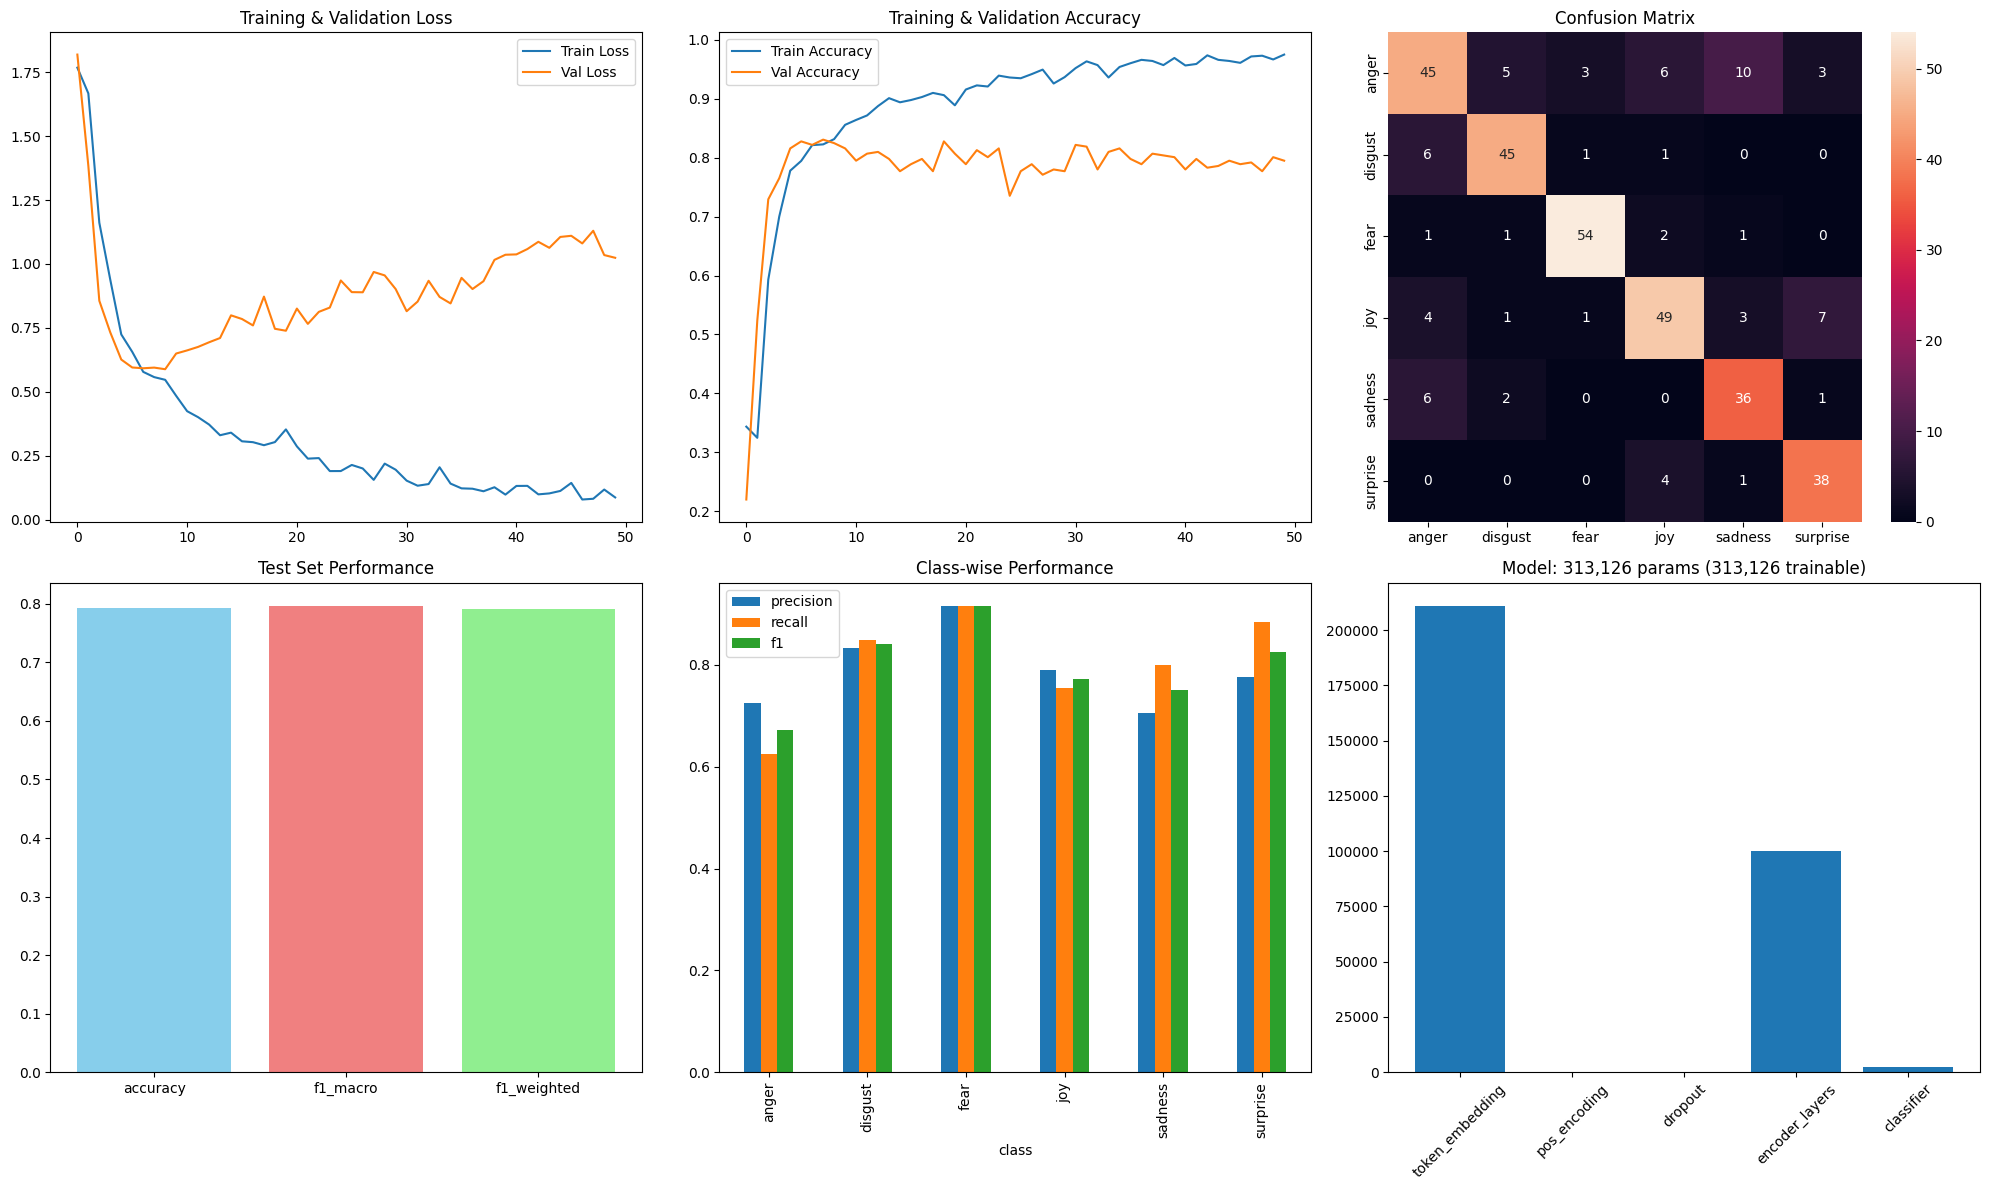

In [22]:
def create_comprehensive_visualizations(history, results, model, class_names):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Training History
    axes[0,0].plot(history['train_loss'], label='Train Loss')
    axes[0,0].plot(history['val_loss'], label='Val Loss')
    axes[0,0].set_title('Training & Validation Loss')
    axes[0,0].legend()
    
    axes[0,1].plot(history['train_acc'], label='Train Accuracy')
    axes[0,1].plot(history['val_acc'], label='Val Accuracy') 
    axes[0,1].set_title('Training & Validation Accuracy')
    axes[0,1].legend()
    
    # 2. Confusion Matrix
    cm = confusion_matrix(results['labels'], results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, 
                yticklabels=class_names, ax=axes[0,2])
    axes[0,2].set_title('Confusion Matrix')
    
    # 3. Performance Metrics
    metrics = ['accuracy', 'f1_macro', 'f1_weighted']
    values = [results[m] for m in metrics]
    axes[1,0].bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[1,0].set_title('Test Set Performance')
    
    # 4. Class-wise Performance
    report = classification_report(results['labels'], results['predictions'], 
                                  output_dict=True, target_names=class_names)
    class_metrics = []
    for cls in class_names:
        class_metrics.append({
            'class': cls,
            'precision': report[cls]['precision'],
            'recall': report[cls]['recall'], 
            'f1': report[cls]['f1-score']
        })
    df_class = pd.DataFrame(class_metrics)
    df_class.plot(x='class', y=['precision', 'recall', 'f1'], 
                  kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Class-wise Performance')
    
    # 5. Model Architecture Summary
    param_count = sum(p.numel() for p in model.parameters())
    trainable_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    layers_info = []
    for name, module in model.named_children():
        layers_info.append({
            'layer': name,
            'parameters': sum(p.numel() for p in module.parameters())
        })
    df_layers = pd.DataFrame(layers_info)
    axes[1,2].bar(df_layers['layer'], df_layers['parameters'])
    axes[1,2].set_title(f'Model: {param_count:,} params ({trainable_count:,} trainable)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage
class_names = train_dataset.label_encoder.classes_
create_comprehensive_visualizations(history, results, model, class_names)